# Developing a Q-Learning Agent to play Cartpole

Note: This notebook was written on Google Colab. 
We recommend using Google Colab to run the codes to avoid any errors:

[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CopsEatingDonuts/Cartpole/blob/main/cartpole_final.ipynb)



#Contributors:

*   Jiang Yunjun: Design and implementation of discretisation mechanism, Q-Table and StateCheck function and relevant documentation



*   Tan Pat Guan: Design, implementation and optimisation of Q-Learning algorithm and relevant documentation

*   Work was split 50-50

Installing dependencies:

In [2]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

In [4]:
env = gym.make("CartPole-v1")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Task 1: Development of an RL agent

We can develop an RL agent using q-learning:

In q learning, we first have to define the possible states of the environment with a Q table of bins.
We initialise the q table with zeroes, 30 bins each for cart position & velocity, 50 bins each for pole position & pole angular velocity to classify each state. Each corresponding state holds 2 values which represents the Q score for each action following this state.


In [5]:
#observation space min [-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38]
#observation space max [4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38]
def QTable():

    qTable = np.zeros(shape=([30, 30, 50, 50] + [2])) #bins and action table
    
    return qTable

With our Q table defined, we are able to check for the action in the table given an observation. However, as Q table is defined and accessed by discrete states, we need to discretise the continuous range of the 4 environment vairables. We design the function checkState() to achieve this, where a transformation is applied by first scaling and then adding a constant. 

In [6]:
def checkState(state):
    discrete_state = state/np.array([0.25, 0.25, 0.01, 0.1])+ np.array([15,10,1,10]) #apply scaling factor and then vertical translation
    return tuple(discrete_state.astype(int)) #convert into integer

With state checking and QTable, we can implement the Q-Learning algorithm. We implemented an epsilon-decay mechanism to encourage the agent to follow the learned policy as the number of episodes increases. A minimum epsilon = 0.05 was set to still allow a very small amount of exploration towards the end of training. 

In [14]:
qTable = QTable() #initialise qtable

alpha = 0.1 #learning rate
discount = 0.95
epsilon = 1
epsilonDecayRate = 0.99

countHist = [] #track learning progress
totalReward = 0
priorReward = 0

for i in range (1, 60001): #number of episodes
    thisState = checkState(env.reset()[0]) #initial state
    ended = False 
    step = 0
    episodeReward = 0

    while not ended:
        step += 1
        if np.random.random() > epsilon:
            action = np.argmax(qTable[thisState]) #get the greedy action
    
        else:
            action = np.random.randint(0,2) #explore random action

        newState, reward, ended, dummy = env.step(action) #take the action

        newDiscState = checkState(newState) #get the new state's discrete version

        if not ended:
            episodeReward += 1
            futureQ = np.max(qTable[newDiscState]) #est future Q value
            curQ = qTable[thisState + (action, )] #current Q value
            newQ = (1-alpha) * curQ + alpha * (reward + discount * futureQ) #calculate new Q
            qTable[thisState + (action, )] = newQ #update Q table with new Q value 
   
 
        thisState = newDiscState #update state
 
 

    if epsilon > 0.05: #epsilon decay modification 
        if episodeReward > priorReward and i > 10000:
            epsilon = epsilon * epsilonDecayRate
 
    else: epsilon = 0.05 #minimum epsilon to maintain some exploration 
 
    totalReward += episodeReward
    priorReward = episodeReward


    if i%5000==0: #check learning progress every 5k episodes
        print("episode number: " + str(i))
        print("mean reward: " + str(totalReward/5000))
        print("\n")
        totalReward = 0


episode number: 5000
mean reward: 21.3882


episode number: 10000
mean reward: 21.1714


episode number: 15000
mean reward: 181.6018


episode number: 20000
mean reward: 214.5362


episode number: 25000
mean reward: 268.312


episode number: 30000
mean reward: 271.6548


episode number: 35000
mean reward: 272.1822


episode number: 40000
mean reward: 313.5346


episode number: 45000
mean reward: 289.8532


episode number: 50000
mean reward: 314.5


episode number: 55000
mean reward: 282.4152


episode number: 60000
mean reward: 318.602




##Demonstration of correctness

To show our implementation is correct, we will sample a random state from the environment for the agent to act on.

In [15]:
sampleState = env.reset()
print("The sample state: " + str(sampleState))
sampleDiscrete = checkState(sampleState)
action = np.argmax(qTable[sampleDiscrete])
print("Agent's chosen action: " + str(action))


The sample state: [ 0.00153335 -0.01126486 -0.0484384  -0.03880834]
Agent's chosen action: 0


#Task 2: Demonstrate the effectiveness of the RL agent

For this task, we use the agent developed in Task 1 to play the game for 100 episodes, record and plot the cumulative reward for each round.

In [16]:
episodeHist = []

for i in range(0,100):
    state = env.reset()[0]
    count = 0
    done = False
    cumulativeReward = 0

    while not done: #our agent here
        cumulativeReward += 1
        discState = checkState(state)
        action = np.argmax(qTable[discState])
        state, reward, done, dummy = env.step(action)
  
    episodeHist.append(cumulativeReward) 

print(episodeHist) #record performance history

[500, 500, 219, 500, 500, 343, 500, 270, 500, 200, 500, 500, 500, 235, 500, 316, 174, 248, 349, 500, 500, 500, 174, 500, 299, 500, 500, 288, 500, 500, 500, 457, 500, 380, 500, 500, 220, 278, 500, 263, 355, 500, 500, 500, 500, 500, 207, 339, 500, 390, 338, 211, 500, 178, 209, 295, 500, 133, 500, 171, 500, 186, 500, 500, 500, 500, 129, 500, 500, 277, 92, 383, 500, 208, 500, 500, 205, 500, 500, 500, 500, 500, 94, 500, 500, 371, 500, 500, 500, 500, 219, 500, 388, 201, 85, 500, 500, 425, 361, 500]


##Graph plot of performance over 100 rounds

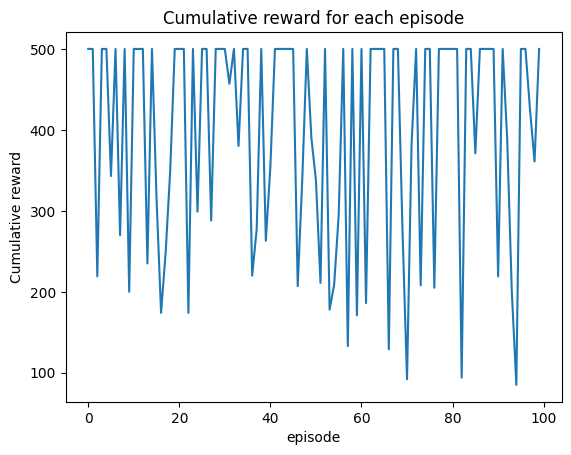

In [17]:
episode_results = episodeHist
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [18]:
resultsArray = np.array(episode_results)
count = resultsArray > 195

print("Average cumulative reward:", resultsArray.mean())
print("Is my agent good enough?", resultsArray.mean() > 195)
print("Episodes with Reward > 195: ", len(resultsArray[count]))


Average cumulative reward: 396.63
Is my agent good enough? True
Episodes with Reward > 195:  90


#Task 3: Render one episode played by the agent

We can now view our agent in action: keeping the pole upright!

In [22]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()[0]
cumulativeReward = 0
while True:
    env.render()
    discState = checkState(observation)
    action = np.argmax(qTable[discState])
    observation, reward, done, info = env.step(action)
    cumulativeReward += 1
    if done: 
        break;    
env.close()
show_video()
print("Reward for this round:" + str(cumulativeReward))

Reward for this round:500
